**Importing all the required libraries**

In [61]:
import tensorflow as tf
import numpy as np
import os
import cv2
import tensorflow_datasets as tfds
from collections import defaultdict
import sklearn
import random
import shutil
import time
from imageio import imwrite
import seaborn as sns
import matplotlib.pyplot as plt

**Downloading the dataset**

In [64]:
import tensorflow_datasets as tfds

# Load MNIST dataset with specified configurations
builder = tfds.builder("mnist")
builder.download_and_prepare()
ds_train = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
ds_info = builder.info


**Preprocessing the train and test data and mounting the google drive**

In [65]:
batch_size = 64
def load_and_preprocess_dataset(dataset, batch_size, cache_dir=None):

    dataset = shuffle_and_batch_dataset(dataset, batch_size)
    dataset = map_preprocess_function(dataset)
    if cache_dir:
        dataset = cache_dataset(dataset, cache_dir)
    dataset = prefetch_dataset(dataset)
    return dataset

def shuffle_and_batch_dataset(dataset, batch_size):

    dataset = dataset.shuffle(ds_info.splits['train'].num_examples)
    dataset = dataset.batch(batch_size)
    return dataset

def map_preprocess_function(dataset):

    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def cache_dataset(dataset, cache_dir):

    dataset = dataset.cache(cache_dir)
    return dataset

def prefetch_dataset(dataset):

    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Preprocess training dataset
ds_train = load_and_preprocess_dataset(ds_train, batch_size, cache_dir='./traindata')

# Preprocess testing dataset
ds_test = load_and_preprocess_dataset(ds_test, batch_size, cache_dir='./testdata')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LENET - 1 MODEL**

In [5]:
def lenet1(input_tensor):

    filters = [4, 12]
    kernel_sizes = [5, 5]
    strides = [1, 1]
    activations = ['tanh', 'tanh']
    pool_sizes = [None, None]

    x = input_tensor
    for i in range(len(filters)):
        x = tf.keras.layers.Conv2D(filters=filters[i],
                                   kernel_size=kernel_sizes[i],
                                   strides=strides[i],
                                   padding='valid',
                                   activation=activations[i])(x)
        if pool_sizes[i]:
            x = tf.keras.layers.AveragePooling2D(pool_size=pool_sizes[i])(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor,
                                  outputs=output_layer,
                                  name='LeNet-1')
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


**LENET - 4 MODEL**

In [6]:
def lenet4(input_tensor):

    filters = [4, 16]
    kernel_sizes = [5, 5]
    strides = [1, 1]
    activations = ['tanh', 'tanh']
    pool_sizes = [None, None]
    dense_units = [120]

    x = input_tensor
    for i in range(len(filters)):
        x = tf.keras.layers.Conv2D(filters=filters[i],
                                   kernel_size=kernel_sizes[i],
                                   strides=strides[i],
                                   padding='valid',
                                   activation=activations[i])(x)
        if pool_sizes[i]:
            x = tf.keras.layers.AveragePooling2D(pool_size=pool_sizes[i])(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation='tanh')(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor,
                                  outputs=output_layer,
                                  name='LeNet-4')
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**Training LENET - 1**

Model: "LeNet-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 20, 12)        1212      
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense_21 (Dense)            (None, 10)                48010     
                                                                 
Total params: 49326 (192.68 KB)
Trainable params: 49326 (192.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
933/938 [=

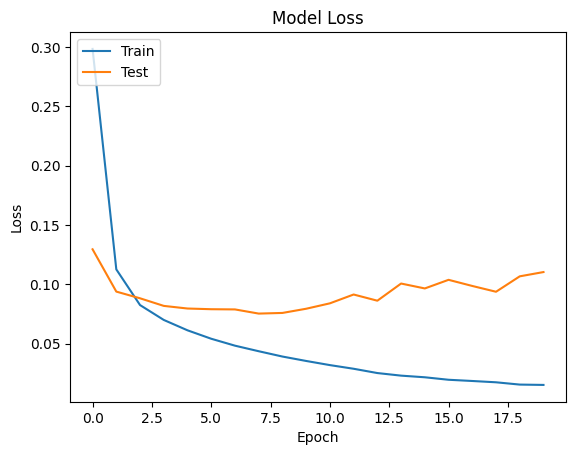

157/157 [==============================] - 1s 3ms/step - loss: 0.1102 - accuracy: 0.9784
Test accuracy: [0.11020317673683167, 0.9783999919891357]


In [38]:
def build_model():

    model = lenet1(tf.keras.Input(shape=(28, 28, 1)))
    return model

def summarize_model(model):

    model.summary()

def train_model(model, train_dataset, test_dataset):

    # Define callback
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        monitor='val_loss',
        filepath='lenet1.best.hdf5',
        verbose=1,
        save_best_only=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=test_dataset,
        verbose=1,
        callbacks=[checkpointer]
    )

    # Plot loss history
    plot_loss_history(history)

    # Evaluate the model
    evaluation = model.evaluate(test_dataset, verbose=1)
    print("Test accuracy:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
model = build_model()
summarize_model(model)
train_model(model, ds_train, ds_test)


**Training LENET - 4**

Model: "LeNet-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_31 (Conv2D)          (None, 20, 20, 16)        1616      
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_19 (Dense)            (None, 120)               768120    
                                                                 
 dense_20 (Dense)            (None, 10)                1210      
                                                                 
Total params: 771050 (2.94 MB)
Trainable params: 771050 (2.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


935/938 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9623
Epoch 2: val_loss improved from 0.14225 to 0.11706, saving model to lenet4.best.hdf5
938/938 [==============================] - 5s 5ms/step - loss: 0.1293 - accuracy: 0.9623 - val_loss: 0.1171 - val_accuracy: 0.9657
Epoch 3/20
931/938 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9696
Epoch 3: val_loss improved from 0.11706 to 0.09737, saving model to lenet4.best.hdf5
938/938 [==============================] - 5s 5ms/step - loss: 0.1025 - accuracy: 0.9696 - val_loss: 0.0974 - val_accuracy: 0.9708
Epoch 4/20
926/938 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9755
Epoch 4: val_loss improved from 0.09737 to 0.08888, saving model to lenet4.best.hdf5
938/938 [==============================] - 4s 5ms/step - loss: 0.0828 - accuracy: 0.9754 - val_loss: 0.0889 - val_accuracy: 0.9747
Epoch 5/20
931/938 [============================>.] - ETA: 0s - loss: 0.073

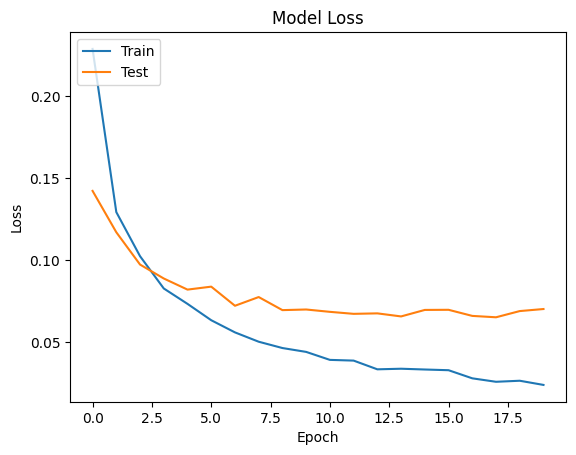

157/157 [==============================] - 0s 3ms/step - loss: 0.0703 - accuracy: 0.9808
Test accuracy: [0.0702805444598198, 0.9807999730110168]


In [37]:
def build_model():

    model = lenet4(tf.keras.Input(shape=(28, 28, 1)))
    return model

def summarize_model(model):

    model.summary()

def train_model(model, train_dataset, test_dataset):

    # Define callback
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        monitor='val_loss',
        filepath='lenet4.best.hdf5',
        verbose=1,
        save_best_only=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=test_dataset,
        verbose=1,
        callbacks=[checkpointer]
    )

    # Plot loss history
    plot_loss_history(history)

    # Evaluate the model
    evaluation = model.evaluate(test_dataset, verbose=1)
    print("Test accuracy:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
model = build_model()
summarize_model(model)
train_model(model, ds_train, ds_test)


In [9]:
input_tensor = tf.keras.layers.Input(shape=(28, 28, 1), name = 'input')
model2 = lenet4(input_tensor= input_tensor)
model1 = lenet1(input_tensor= input_tensor)

In [10]:
model2.load_weights('/content/lenet4.best.hdf5')
model1.load_weights('/content/lenet1.best.hdf5')

**MNIST Training with different transformation**

In [11]:
def load_images(path):
    images = []
    labels = []

    # Iterate over directories in the path
    for directory in os.listdir(path):
        if os.path.isdir(os.path.join(path, directory)):
            # Iterate over files in each directory
            for file in os.listdir(os.path.join(path, directory)):
                if os.path.isfile(os.path.join(path, directory, file)):
                    # Read images and convert to grayscale
                    image_path = os.path.join(path, directory, file)
                    image = cv2.imread(image_path)
                    if image is not None:
                        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        images.append(grayscale_image)
                        labels.append(int(directory))

    return images, labels


**USING EXAMPLES GENERATED FROM TRAINING SET**

In [68]:
images, labels = load_images('/content/drive/My Drive/MNIST data/train_set_generated/generated_inputs_blackout_train')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**Blackout transformation (LENET - 1)**

Model: "LeNet-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 20, 12)        1212      
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense_22 (Dense)            (None, 10)                48010     
                                                                 
Total params: 49326 (192.68 KB)
Trainable params: 49326 (192.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [============

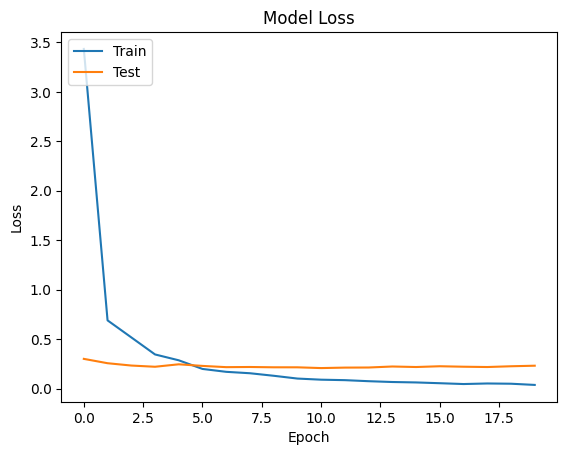

157/157 [==============================] - 1s 3ms/step - loss: 0.2307 - accuracy: 0.9611
Accuracy after retraining: [0.2306639701128006, 0.9610999822616577]


In [66]:
def load_and_evaluate_model1_black(model, test_dataset):
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
    model.summary()
    evaluation = model.evaluate(test_dataset)
    print("Accuracy before retraining:", evaluation)

def train_and_plot_history1_black(model, train_images, train_labels, test_dataset, batch_size, epochs):
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
input_tensor3 = tf.keras.layers.Input(shape=(28, 28, 1), name='input')
model_1 = lenet1(input_tensor=input_tensor3)

load_and_evaluate_model1_black(model_1, ds_test)
train_and_plot_history1_black(model_1, images, labels, ds_test, batch_size=64, epochs=20)
evaluation_after_retraining = model_1.evaluate(ds_test)
print("Accuracy after retraining:", evaluation_after_retraining)

**Blackout transformation (LENET - 4)**

Model: "LeNet-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 16)        1616      
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 120)               768120    
                                                                 
 dense_9 (Dense)             (None, 10)                1210      
                                                                 
Total params: 771050 (2.94 MB)
Trainable params: 771050 (2.

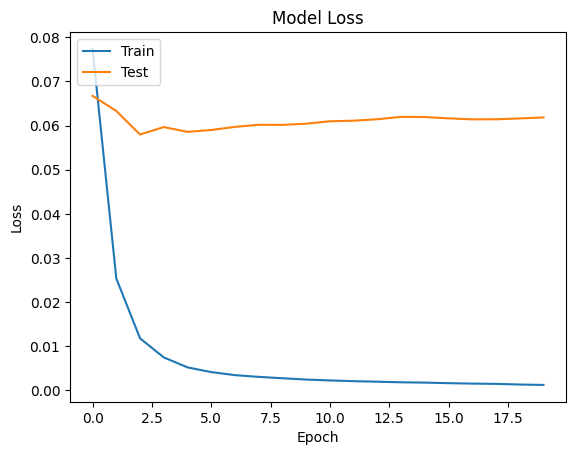

157/157 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.9823
Accuracy after retraining: [0.061840325593948364, 0.9822999835014343]


In [15]:
def load_and_evaluate_model2(model, test_dataset):
    model.load_weights('/content/lenet4.best.hdf5')
    model.summary()
    evaluation = model.evaluate(test_dataset)
    print("Accuracy before retraining:", evaluation)

def train_and_plot_history2(model, train_images, train_labels, test_dataset, batch_size, epochs):
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

input_tensor2 = tf.keras.layers.Input(shape=(28, 28, 1), name='input')
model_2 = lenet4(input_tensor=input_tensor2)

load_and_evaluate_model2(model_2, ds_test)
train_and_plot_history2(model_2, images, labels, ds_test, batch_size=64, epochs=20)
evaluation_after_retraining = model_2.evaluate(ds_test)
print("Accuracy after retraining:", evaluation_after_retraining)

**Using Light Transformation**

In [17]:
images, labels = load_images('/content/drive/My Drive/MNIST data/train_set_generated/generated_inputs_light')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**LENET - 1**

Epoch 1/20
45/45 [==============================] - 1s 18ms/step - loss: 3.6564 - accuracy: 0.6409 - val_loss: 0.3741 - val_accuracy: 0.9346
Epoch 2/20
45/45 [==============================] - 0s 11ms/step - loss: 0.3345 - accuracy: 0.9135 - val_loss: 0.2917 - val_accuracy: 0.9469
Epoch 3/20
45/45 [==============================] - 0s 11ms/step - loss: 0.2367 - accuracy: 0.9291 - val_loss: 0.2587 - val_accuracy: 0.9521
Epoch 4/20
45/45 [==============================] - 1s 18ms/step - loss: 0.1573 - accuracy: 0.9507 - val_loss: 0.2426 - val_accuracy: 0.9541
Epoch 5/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1269 - accuracy: 0.9599 - val_loss: 0.2470 - val_accuracy: 0.9540
Epoch 6/20
45/45 [==============================] - 0s 11ms/step - loss: 0.0985 - accuracy: 0.9713 - val_loss: 0.2388 - val_accuracy: 0.9554
Epoch 7/20
45/45 [==============================] - 0s 11ms/step - loss: 0.0859 - accuracy: 0.9731 - val_loss: 0.2507 - val_accuracy: 0.9518
Epoch 8/20
45

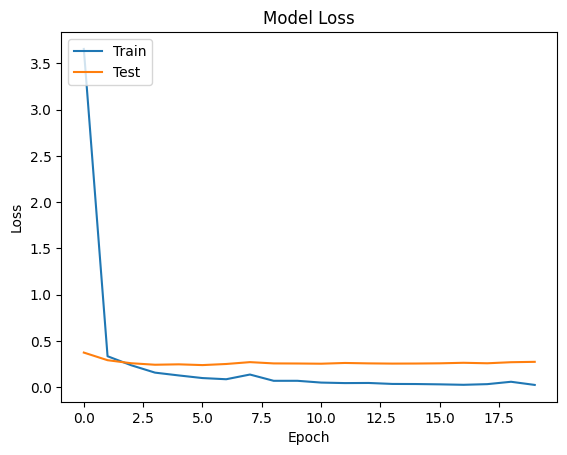

157/157 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.9517
Accuracy after retraining: [0.2739652693271637, 0.95169997215271]


In [18]:
def load_and_train_model1_light(model, train_images, train_labels, test_dataset, batch_size, epochs):
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)
    evaluation_after_retraining = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation_after_retraining)

# Example usage:
load_and_train_model1_light(model_1, images, labels, ds_test, batch_size=64, epochs=20)


**LENET - 4**

Epoch 1/20
45/45 [==============================] - 1s 14ms/step - loss: 0.7542 - accuracy: 0.8228 - val_loss: 0.1438 - val_accuracy: 0.9585
Epoch 2/20
45/45 [==============================] - 1s 18ms/step - loss: 0.3029 - accuracy: 0.8926 - val_loss: 0.1498 - val_accuracy: 0.9594
Epoch 3/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1598 - accuracy: 0.9454 - val_loss: 0.1702 - val_accuracy: 0.9547
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.1042 - accuracy: 0.9624 - val_loss: 0.1410 - val_accuracy: 0.9625
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0634 - accuracy: 0.9794 - val_loss: 0.1494 - val_accuracy: 0.9598
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 0.1471 - val_accuracy: 0.9591
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.1453 - val_accuracy: 0.9600
Epoch 8/20
45

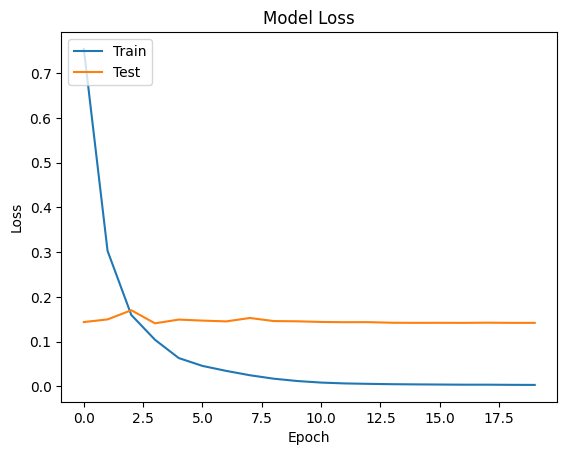

157/157 [==============================] - 1s 4ms/step - loss: 0.1421 - accuracy: 0.9629
Accuracy after retraining: [0.1420523077249527, 0.9628999829292297]


In [19]:
def load_and_train_model2_light(model, train_images, train_labels, test_dataset, batch_size, epochs):
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet4.best.hdf5')
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)
    evaluation_after_retraining = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation_after_retraining)

# Example usage:
load_and_train_model2_light(model_2, images, labels, ds_test, batch_size=64, epochs=20)


**Using Occlusion**

In [20]:
images, labels = load_images('/content/drive/My Drive/MNIST data/train_set_generated/generated_inputs_occl')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**LENET - 1**

Epoch 1/20
1/1 [==============================] - 1s 823ms/step - loss: 0.0873 - accuracy: 0.9661 - val_loss: 0.0681 - val_accuracy: 0.9816
Epoch 2/20
1/1 [==============================] - 0s 314ms/step - loss: 0.0691 - accuracy: 0.9661 - val_loss: 0.0685 - val_accuracy: 0.9819
Epoch 3/20
1/1 [==============================] - 0s 317ms/step - loss: 0.0439 - accuracy: 0.9831 - val_loss: 0.0691 - val_accuracy: 0.9819
Epoch 4/20
1/1 [==============================] - 0s 320ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.0699 - val_accuracy: 0.9817
Epoch 5/20
1/1 [==============================] - 0s 312ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9817
Epoch 6/20
1/1 [==============================] - 0s 330ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0717 - val_accuracy: 0.9811
Epoch 7/20
1/1 [==============================] - 1s 637ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 0.9812
Epoch 8/20
1/1 [====

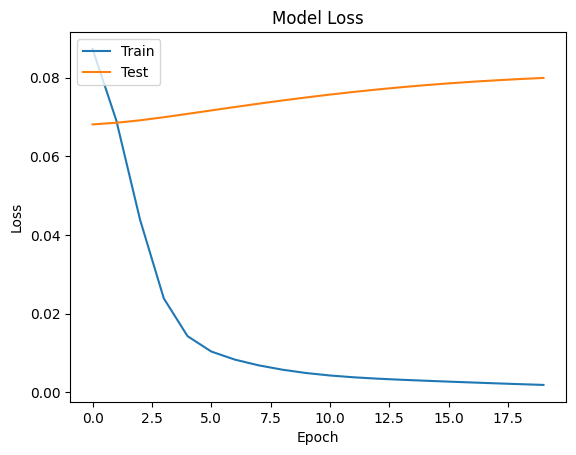

157/157 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9807
Accuracy after retraining: [0.07991190999746323, 0.9807000160217285]


In [21]:
def load_and_train_model1_occ(model, train_images, train_labels, test_dataset, batch_size, epochs):
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)
    evaluation_after_retraining = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation_after_retraining)

# Example usage:
load_and_train_model1_occ(model_1, images, labels, ds_test, batch_size=64, epochs=20)


**LENET - 4**

Epoch 1/20
1/1 [==============================] - 0s 448ms/step - loss: 0.1179 - accuracy: 0.9661 - val_loss: 0.0576 - val_accuracy: 0.9820
Epoch 2/20
1/1 [==============================] - 0s 350ms/step - loss: 0.0505 - accuracy: 0.9831 - val_loss: 0.0574 - val_accuracy: 0.9818
Epoch 3/20
1/1 [==============================] - 0s 348ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0571 - val_accuracy: 0.9825
Epoch 4/20
1/1 [==============================] - 0s 339ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0571 - val_accuracy: 0.9829
Epoch 5/20
1/1 [==============================] - 1s 637ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9829
Epoch 6/20
1/1 [==============================] - 0s 345ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9830
Epoch 7/20
1/1 [==============================] - 1s 639ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0577 - val_accuracy: 0.9829
Epoch 8/20
1/1 [====

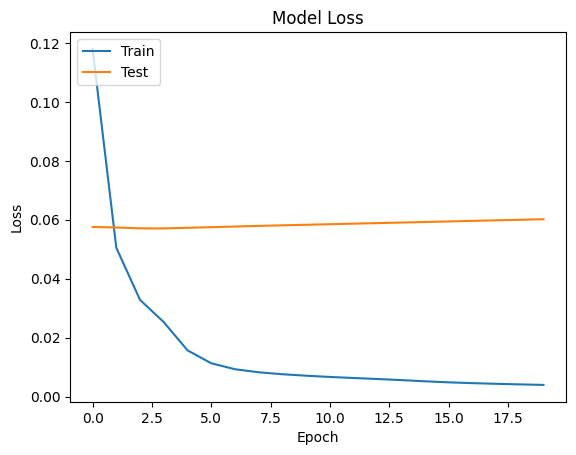

157/157 [==============================] - 0s 3ms/step - loss: 0.0602 - accuracy: 0.9816
Accuracy after retraining: [0.0601743645966053, 0.9815999865531921]


In [22]:
def load_and_train_model2_occ(model, train_images, train_labels, test_dataset, batch_size, epochs):
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet4.best.hdf5')
    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)
    evaluation_after_retraining = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation_after_retraining)

# Example usage:
load_and_train_model2_occ(model_2, images, labels, ds_test, batch_size=64, epochs=20)


**NOW USING EXAMPLES GENERATED FROM TEST SET**

In [23]:
images, labels = load_images('/content/drive/My Drive/MNIST data/test_set_generated/generated_inputs_blackout')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**Blackout Transformation (LENET - 1)**

Model: "LeNet-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 12)        1212      
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense_10 (Dense)            (None, 10)                48010     
                                                                 
Total params: 49326 (192.68 KB)
Trainable params: 49326 (192.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [============

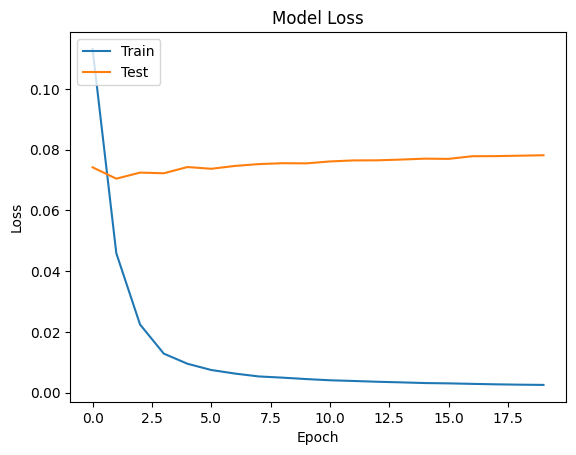

In [29]:
def load_pretrained_model(input_tensor):

    model = lenet1(input_tensor=input_tensor)
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
    return model

def evaluate_model(model, test_dataset):

    model.summary()
    evaluation = model.evaluate(test_dataset)
    print("Accuracy before retraining:", evaluation)
    return evaluation

def train_and_plot_history1_black_(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)

def plot_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
input_tensor3 = tf.keras.layers.Input(shape=(28, 28, 1), name='input')
model_3 = load_pretrained_model(input_tensor3)
evaluation_before_retraining = evaluate_model(model_1, ds_test)
train_and_plot_history1_black_(model_1, images, labels, ds_test, batch_size=64, epochs=20)


**Blackout Transformation (LENET - 4)**

Model: "LeNet-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 20, 16)        1616      
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_17 (Dense)            (None, 120)               768120    
                                                                 
 dense_18 (Dense)            (None, 10)                1210      
                                                                 
Total params: 771050 (2.94 MB)
Trainable params: 771050 (2.

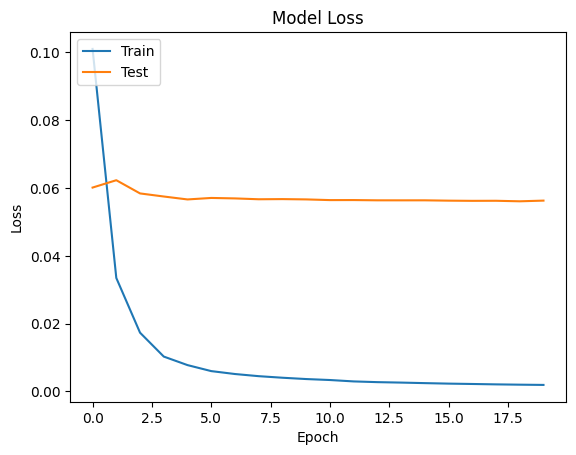

In [30]:
def load_pretrained_model(input_tensor):

    model = lenet4(input_tensor=input_tensor)
    model.load_weights('/content/drive/My Drive/MNIST data/models/lenet4.best.hdf5')
    return model

def evaluate_model(model, test_dataset):

    model.summary()
    evaluation = model.evaluate(test_dataset)
    print("Accuracy before retraining:", evaluation)
    return evaluation

def train_and_plot_history(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)
    plot_history(history)

def plot_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
input_tensor2 = tf.keras.layers.Input(shape=(28, 28, 1), name='input')
model_2 = load_pretrained_model(input_tensor2)
evaluation_before_retraining = evaluate_model(model_2, ds_test)
train_and_plot_history(model_2, images, labels, ds_test, batch_size=64, epochs=20)


**Light transformation**

In [31]:
images, labels = load_images('/content/drive/My Drive/MNIST data/test_set_generated/generated_inputs_light')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**LENET - 1**

Epoch 1/20
45/45 [==============================] - 1s 15ms/step - loss: 3.7502 - accuracy: 0.6346 - val_loss: 0.3238 - val_accuracy: 0.9441
Epoch 2/20
45/45 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.8941 - val_loss: 0.2874 - val_accuracy: 0.9522
Epoch 3/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1812 - accuracy: 0.9434 - val_loss: 0.2549 - val_accuracy: 0.9563
Epoch 4/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1411 - accuracy: 0.9566 - val_loss: 0.2524 - val_accuracy: 0.9549
Epoch 5/20
45/45 [==============================] - 0s 11ms/step - loss: 0.1071 - accuracy: 0.9668 - val_loss: 0.2454 - val_accuracy: 0.9560
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 0.0918 - accuracy: 0.9710 - val_loss: 0.2564 - val_accuracy: 0.9543
Epoch 7/20
45/45 [==============================] - 1s 11ms/step - loss: 0.0680 - accuracy: 0.9801 - val_loss: 0.2430 - val_accuracy: 0.9576
Epoch 8/20
45

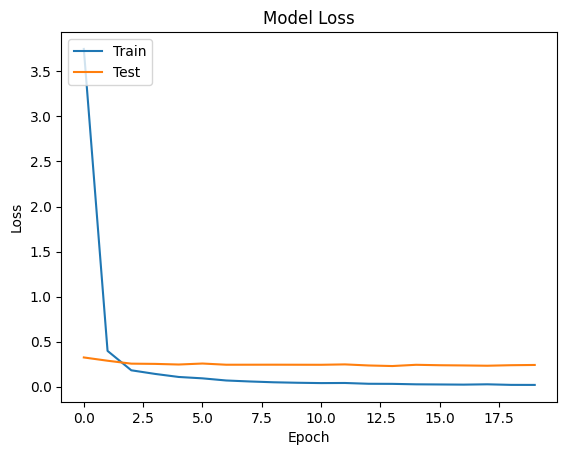

157/157 [==============================] - 1s 6ms/step - loss: 0.2404 - accuracy: 0.9594
Accuracy after retraining: [0.24038173258304596, 0.9593999981880188]


In [32]:
def load_pretrained_weights(model, weights_path):

    model.load_weights(weights_path)

def train_and_evaluate_model1_light_(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)

    plot_loss_history(history)

    evaluation = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
load_pretrained_weights(model_1, '/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
train_and_evaluate_model1_light_(model_1, images, labels, ds_test, batch_size=64, epochs=20)


**LENET - 4**

Epoch 1/20
45/45 [==============================] - 1s 20ms/step - loss: 0.9228 - accuracy: 0.7734 - val_loss: 0.1390 - val_accuracy: 0.9626
Epoch 2/20
45/45 [==============================] - 1s 18ms/step - loss: 0.2164 - accuracy: 0.9315 - val_loss: 0.1341 - val_accuracy: 0.9638
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1078 - accuracy: 0.9626 - val_loss: 0.1296 - val_accuracy: 0.9647
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0596 - accuracy: 0.9818 - val_loss: 0.1245 - val_accuracy: 0.9675
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0478 - accuracy: 0.9860 - val_loss: 0.1201 - val_accuracy: 0.9690
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 0.0307 - accuracy: 0.9937 - val_loss: 0.1150 - val_accuracy: 0.9697
Epoch 7/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0229 - accuracy: 0.9958 - val_loss: 0.1197 - val_accuracy: 0.9680
Epoch 8/20
45

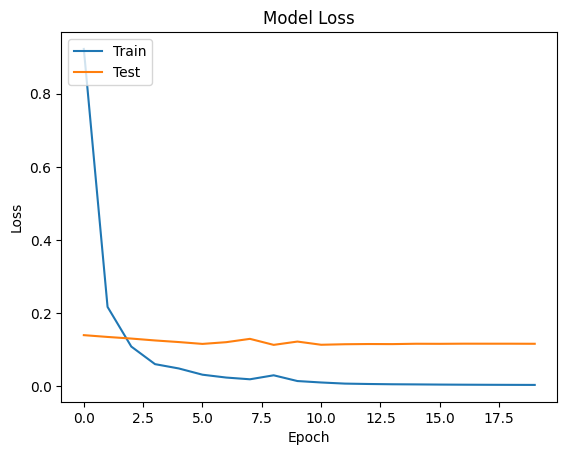

157/157 [==============================] - 1s 3ms/step - loss: 0.1154 - accuracy: 0.9702
Accuracy after retraining: [0.11535696685314178, 0.9702000021934509]


In [33]:
def load_pretrained_weights(model, weights_path):

    model.load_weights(weights_path)

def train_and_evaluate_model2_light_(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)

    plot_loss_history(history)

    evaluation = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
load_pretrained_weights(model_2, '/content/drive/My Drive/MNIST data/models/lenet4.best.hdf5')
train_and_evaluate_model2_light_(model_2, images, labels, ds_test, batch_size=64, epochs=20)


**Occlusion Transformation**

In [ ]:
images, labels = load_images('/content/drive/My Drive/MNIST data/test_set_generated/generated_inputs_occl')
images, labels = tf.convert_to_tensor(images), tf.one_hot(labels, 10)

**LENET - 1**

Epoch 1/20
45/45 [==============================] - 2s 14ms/step - loss: 3.9587 - accuracy: 0.5612 - val_loss: 0.2933 - val_accuracy: 0.9421
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 0.7428 - accuracy: 0.7762 - val_loss: 0.2273 - val_accuracy: 0.9546
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.5406 - accuracy: 0.8325 - val_loss: 0.2257 - val_accuracy: 0.9579
Epoch 4/20
45/45 [==============================] - 1s 12ms/step - loss: 0.3922 - accuracy: 0.8766 - val_loss: 0.2242 - val_accuracy: 0.9587
Epoch 5/20
45/45 [==============================] - 1s 11ms/step - loss: 0.3092 - accuracy: 0.9042 - val_loss: 0.2169 - val_accuracy: 0.9604
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 0.2463 - accuracy: 0.9203 - val_loss: 0.2307 - val_accuracy: 0.9582
Epoch 7/20
45/45 [==============================] - 1s 18ms/step - loss: 0.1926 - accuracy: 0.9371 - val_loss: 0.2206 - val_accuracy: 0.9594
Epoch 8/20
45

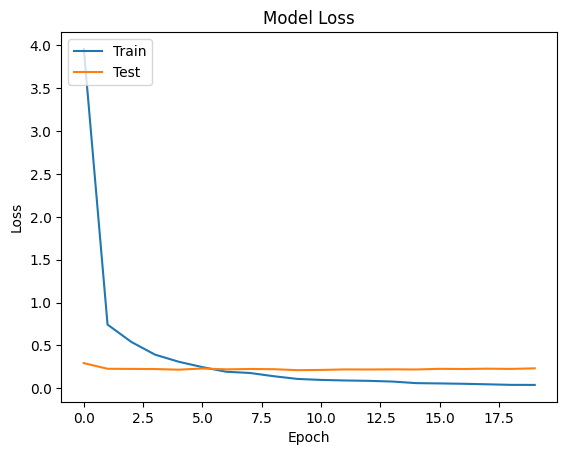

157/157 [==============================] - 0s 3ms/step - loss: 0.2323 - accuracy: 0.9603
Accuracy after retraining: [0.2323298156261444, 0.9603000283241272]


In [34]:
def load_pretrained_weights(model, weights_path):

    model.load_weights(weights_path)

def train_and_evaluate_model1_occ_(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)

    plot_loss_history(history)

    evaluation = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
load_pretrained_weights(model_1, '/content/drive/My Drive/MNIST data/models/lenet1.best.hdf5')
train_and_evaluate_model1_occ_(model_1, images, labels, ds_test, batch_size=64, epochs=20)


**LENET - 4**

Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 1.1073 - accuracy: 0.7157 - val_loss: 0.1196 - val_accuracy: 0.9666
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 0.2389 - accuracy: 0.9255 - val_loss: 0.1142 - val_accuracy: 0.9687
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1671 - accuracy: 0.9455 - val_loss: 0.1111 - val_accuracy: 0.9694
Epoch 4/20
45/45 [==============================] - 1s 11ms/step - loss: 0.1122 - accuracy: 0.9636 - val_loss: 0.1055 - val_accuracy: 0.9703
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 0.0920 - accuracy: 0.9755 - val_loss: 0.1065 - val_accuracy: 0.9721
Epoch 6/20
45/45 [==============================] - 1s 18ms/step - loss: 0.0649 - accuracy: 0.9808 - val_loss: 0.1102 - val_accuracy: 0.9707
Epoch 7/20
45/45 [==============================] - 1s 18ms/step - loss: 0.0518 - accuracy: 0.9867 - val_loss: 0.1056 - val_accuracy: 0.9725
Epoch 8/20
45

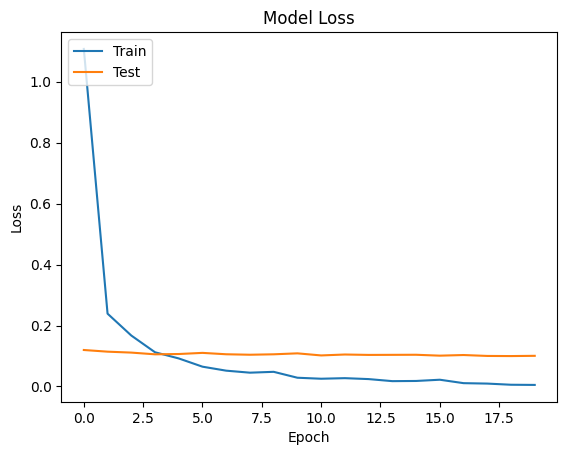

157/157 [==============================] - 1s 6ms/step - loss: 0.1005 - accuracy: 0.9734
Accuracy after retraining: [0.10052089393138885, 0.9733999967575073]


In [36]:
def load_pretrained_weights(model, weights_path):

    model.load_weights(weights_path)

def train_and_evaluate_model(model, train_images, train_labels, test_dataset, batch_size, epochs):

    history = model.fit(tf.divide(tf.cast(train_images, tf.float32), tf.constant(255.0)),
                        train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=test_dataset)

    plot_loss_history(history)

    evaluation = model.evaluate(test_dataset)
    print("Accuracy after retraining:", evaluation)

def plot_loss_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Example usage:
load_pretrained_weights(model_2, '/content/drive/My Drive/MNIST data/models/lenet4.best.hdf5')
train_and_evaluate_model(model_2, images, labels, ds_test, batch_size=64, epochs=20)
